### Setup Environment:

In [1]:
from src.get_dataset import split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'images/')
LABEL = 'DR_ICDR'
TEST_SIZE = 0.7
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'image_id'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None # [0.485, 0.456, 0.406]
NORM_STD = None # [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_base'
MODE = 'fine_tune'
backbone_mode = 'eval'

HIDDEN = [128]
num_classes = 3

BATCH_SIZE = 16
NUM_WORKERS = 4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df_train = pd.read_csv(os.path.join(DATASET, 'train_ssl.csv'))
df_test = pd.read_csv(os.path.join(DATASET, 'test_ssl.csv'))

In [4]:
# Convert into 2 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# Map values to categories
df_train[LABEL] = df_train[LABEL].apply(lambda x: 'Normal' if x == 0 else ('Non-proliferative' if x in [1, 2, 3] else 'Proliferative'))
df_test[LABEL] = df_test[LABEL].apply(lambda x: 'Normal' if x == 0 else ('Non-proliferative' if x in [1, 2, 3] else 'Proliferative'))

Getting validation set...
Train data shape: (5205, 35)
Test data shape: (1302, 35)


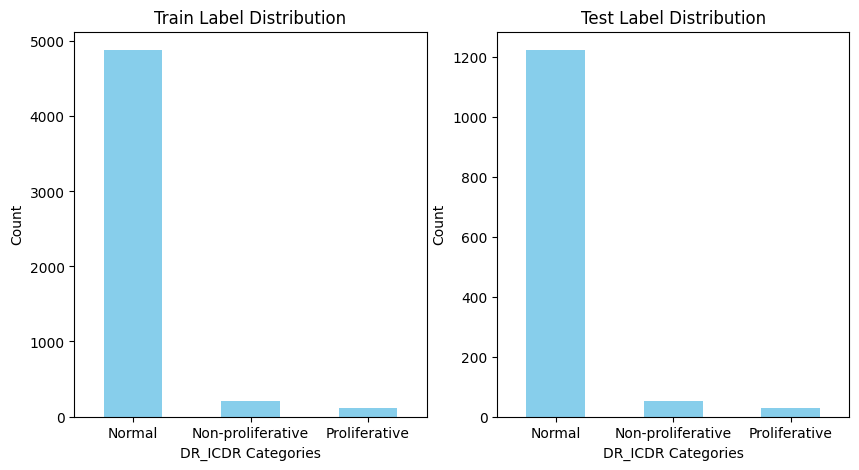

In [5]:
# Split dataset into train, test and validation:
#df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.20)

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [7]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [8]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

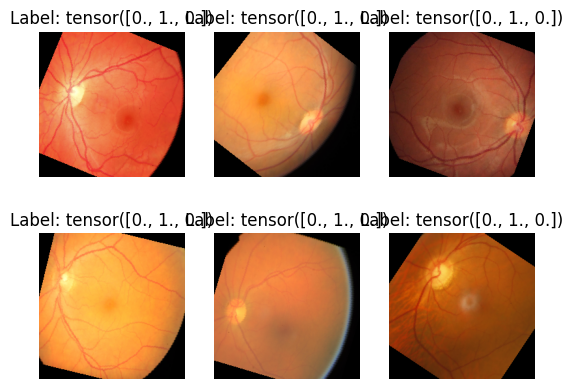

In [9]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [10]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
# Load backbone weights:
backbone_model.load_state_dict(torch.load('Models/checkpoint_convnextv2_base_byol.pt'))
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using 2 GPUs!


### Training:

In [11]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [12]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'convnextv2_binary_{LABEL}_byol')

100%|██████████| 82/82 [00:23<00:00,  3.44it/s]


Epoch 1, Train Loss: 1.0393091348839587, Val Loss: 1.1006301877702154, F1 Score: 0.3315207180264983


100%|██████████| 82/82 [00:23<00:00,  3.52it/s]


Epoch 2, Train Loss: 0.9482123661236684, Val Loss: 1.4353932162247054, F1 Score: 0.20937988966894436


100%|██████████| 82/82 [00:23<00:00,  3.50it/s]


Epoch 3, Train Loss: 0.9340936259168093, Val Loss: 0.7339925277160435, F1 Score: 0.6045423345541536


100%|██████████| 82/82 [00:23<00:00,  3.42it/s]


Epoch 4, Train Loss: 0.8548362071396874, Val Loss: 0.7615749325330664, F1 Score: 0.609810809532746


100%|██████████| 82/82 [00:23<00:00,  3.56it/s]


Epoch 5, Train Loss: 0.812262594577719, Val Loss: 0.7398169500435271, F1 Score: 0.5952647543850212


100%|██████████| 82/82 [00:23<00:00,  3.48it/s]


Epoch 6, Train Loss: 0.783018636483638, Val Loss: 0.6497216817082428, F1 Score: 0.6609097332357367


100%|██████████| 82/82 [00:23<00:00,  3.42it/s]


Epoch 7, Train Loss: 0.744210253753623, Val Loss: 0.7619189607297502, F1 Score: 0.5085277593383514


100%|██████████| 82/82 [00:23<00:00,  3.53it/s]


Epoch 8, Train Loss: 0.7933793391604893, Val Loss: 0.7373256619747092, F1 Score: 0.632909501139146


100%|██████████| 82/82 [00:23<00:00,  3.53it/s]


Epoch 9, Train Loss: 0.7078249124840634, Val Loss: 0.6135546076225071, F1 Score: 0.5643273808694695


100%|██████████| 82/82 [00:23<00:00,  3.45it/s]


Epoch 10, Train Loss: 0.7228620408011265, Val Loss: 0.6525047852135286, F1 Score: 0.6793586677254561


100%|██████████| 82/82 [00:23<00:00,  3.43it/s]


Epoch 11, Train Loss: 0.6870814488315191, Val Loss: 0.5832423180705164, F1 Score: 0.6397470509010916


100%|██████████| 82/82 [00:24<00:00,  3.40it/s]


Epoch 12, Train Loss: 0.6734970986110265, Val Loss: 0.5277130950878306, F1 Score: 0.7064173686733787


100%|██████████| 82/82 [00:23<00:00,  3.51it/s]


Epoch 13, Train Loss: 0.6779907589075995, Val Loss: 0.701743013248211, F1 Score: 0.47365679527898036


100%|██████████| 82/82 [00:23<00:00,  3.50it/s]


Epoch 14, Train Loss: 0.6733172056860611, Val Loss: 1.1418572762390462, F1 Score: 0.4015241819445113


100%|██████████| 82/82 [00:23<00:00,  3.48it/s]


Epoch 15, Train Loss: 0.629813081710065, Val Loss: 0.6703480114115448, F1 Score: 0.7150102659964178


100%|██████████| 82/82 [00:24<00:00,  3.41it/s]


Epoch 16, Train Loss: 0.5963401444989149, Val Loss: 0.5463508492017665, F1 Score: 0.6993084252526224


100%|██████████| 82/82 [00:23<00:00,  3.44it/s]


Epoch 17, Train Loss: 0.5453668558573137, Val Loss: 0.5020547376536741, F1 Score: 0.7191832241204631


100%|██████████| 82/82 [00:23<00:00,  3.50it/s]


Epoch 18, Train Loss: 0.5365490681262779, Val Loss: 0.7372897267341614, F1 Score: 0.7593993069444197


100%|██████████| 82/82 [00:23<00:00,  3.48it/s]


Epoch 19, Train Loss: 0.5141279016911495, Val Loss: 0.9598130992182144, F1 Score: 0.6821612249678232


100%|██████████| 82/82 [00:23<00:00,  3.42it/s]


Epoch 20, Train Loss: 0.4959479519211855, Val Loss: 0.4851370085394237, F1 Score: 0.797579720542129


100%|██████████| 82/82 [00:23<00:00,  3.52it/s]


Epoch 21, Train Loss: 0.4733229119941348, Val Loss: 0.5169091214675728, F1 Score: 0.7125715810514136


100%|██████████| 82/82 [00:22<00:00,  3.57it/s]


Epoch 22, Train Loss: 0.46569281657088973, Val Loss: 0.4928709892783223, F1 Score: 0.800803753041325


100%|██████████| 82/82 [00:24<00:00,  3.38it/s]


Epoch 23, Train Loss: 0.41228207152520047, Val Loss: 0.5387419737057715, F1 Score: 0.7420661806827838


100%|██████████| 82/82 [00:23<00:00,  3.50it/s]


Epoch 24, Train Loss: 0.4254607906229183, Val Loss: 0.9820972525673669, F1 Score: 0.7987981635279984


100%|██████████| 82/82 [00:23<00:00,  3.49it/s]


Epoch 25, Train Loss: 0.3638645034161259, Val Loss: 0.5859597615625073, F1 Score: 0.7837537570574278


100%|██████████| 82/82 [00:24<00:00,  3.35it/s]


Epoch 26, Train Loss: 0.3590665390318046, Val Loss: 0.6137169465059187, F1 Score: 0.7985489158471036


100%|██████████| 82/82 [00:24<00:00,  3.38it/s]


Epoch 27, Train Loss: 0.3359643249299194, Val Loss: 0.44369686751558285, F1 Score: 0.8313294548588667


100%|██████████| 82/82 [00:23<00:00,  3.51it/s]


Epoch 28, Train Loss: 0.41840834819146844, Val Loss: 0.5536468793615336, F1 Score: 0.7997502960463475


100%|██████████| 82/82 [00:23<00:00,  3.53it/s]


Epoch 29, Train Loss: 0.36592524588169134, Val Loss: 0.5839089084552919, F1 Score: 0.7951764025348891


100%|██████████| 82/82 [00:23<00:00,  3.44it/s]


Epoch 30, Train Loss: 0.3011419859180441, Val Loss: 0.5618897806853056, F1 Score: 0.7949447856367824


 97%|█████████▋| 591/610 [03:09<00:05,  3.17it/s]

### Test

100%|██████████| 326/326 [01:30<00:00,  3.59it/s]


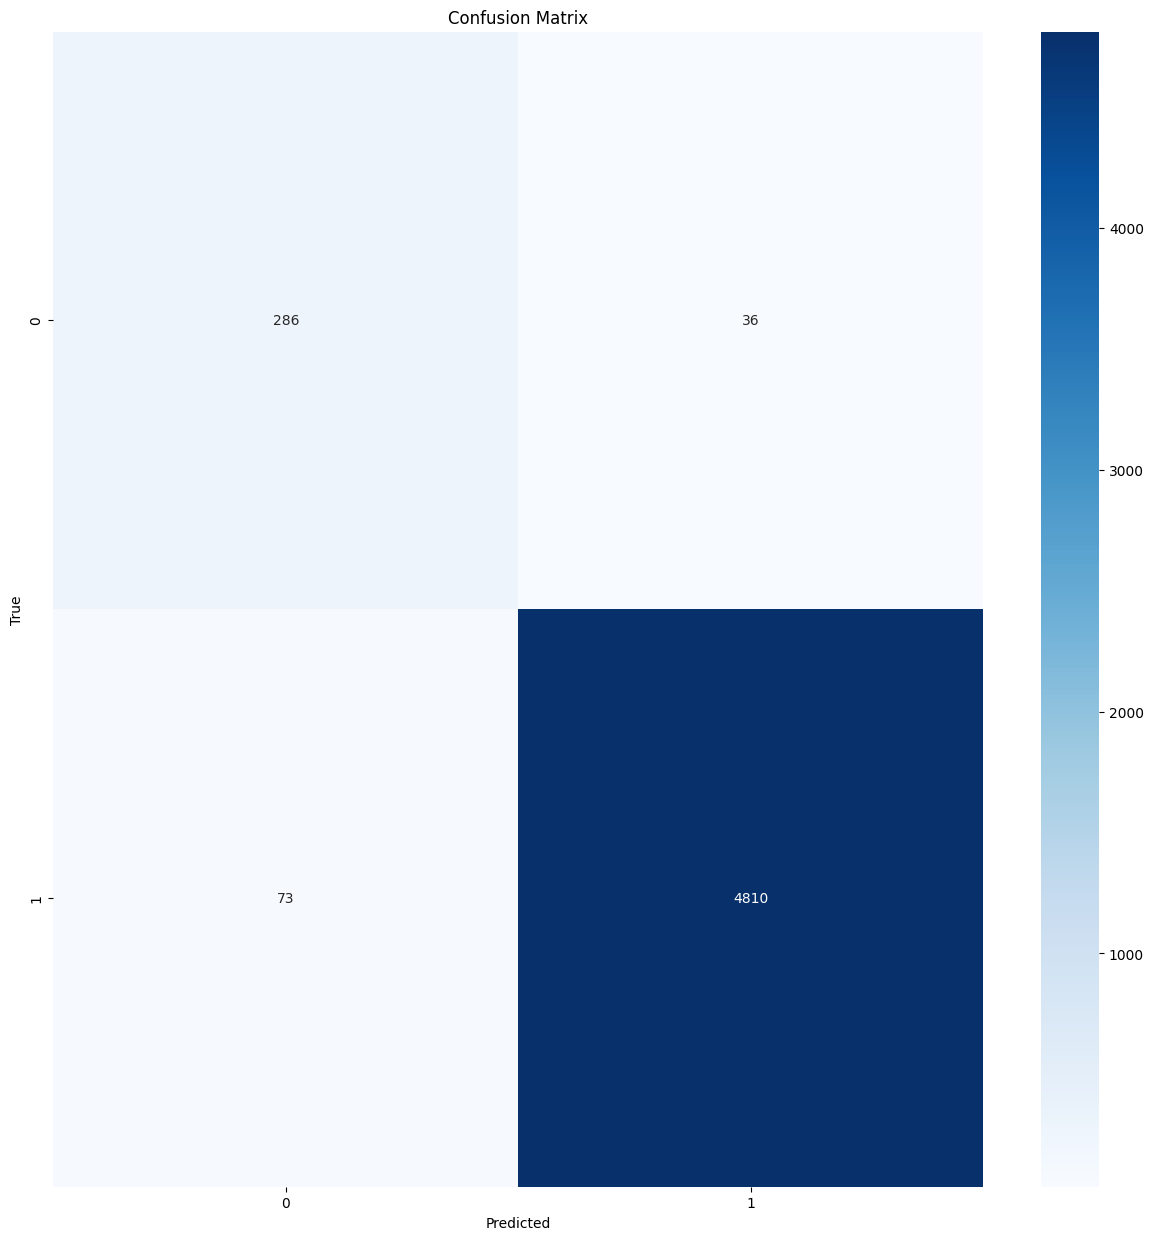

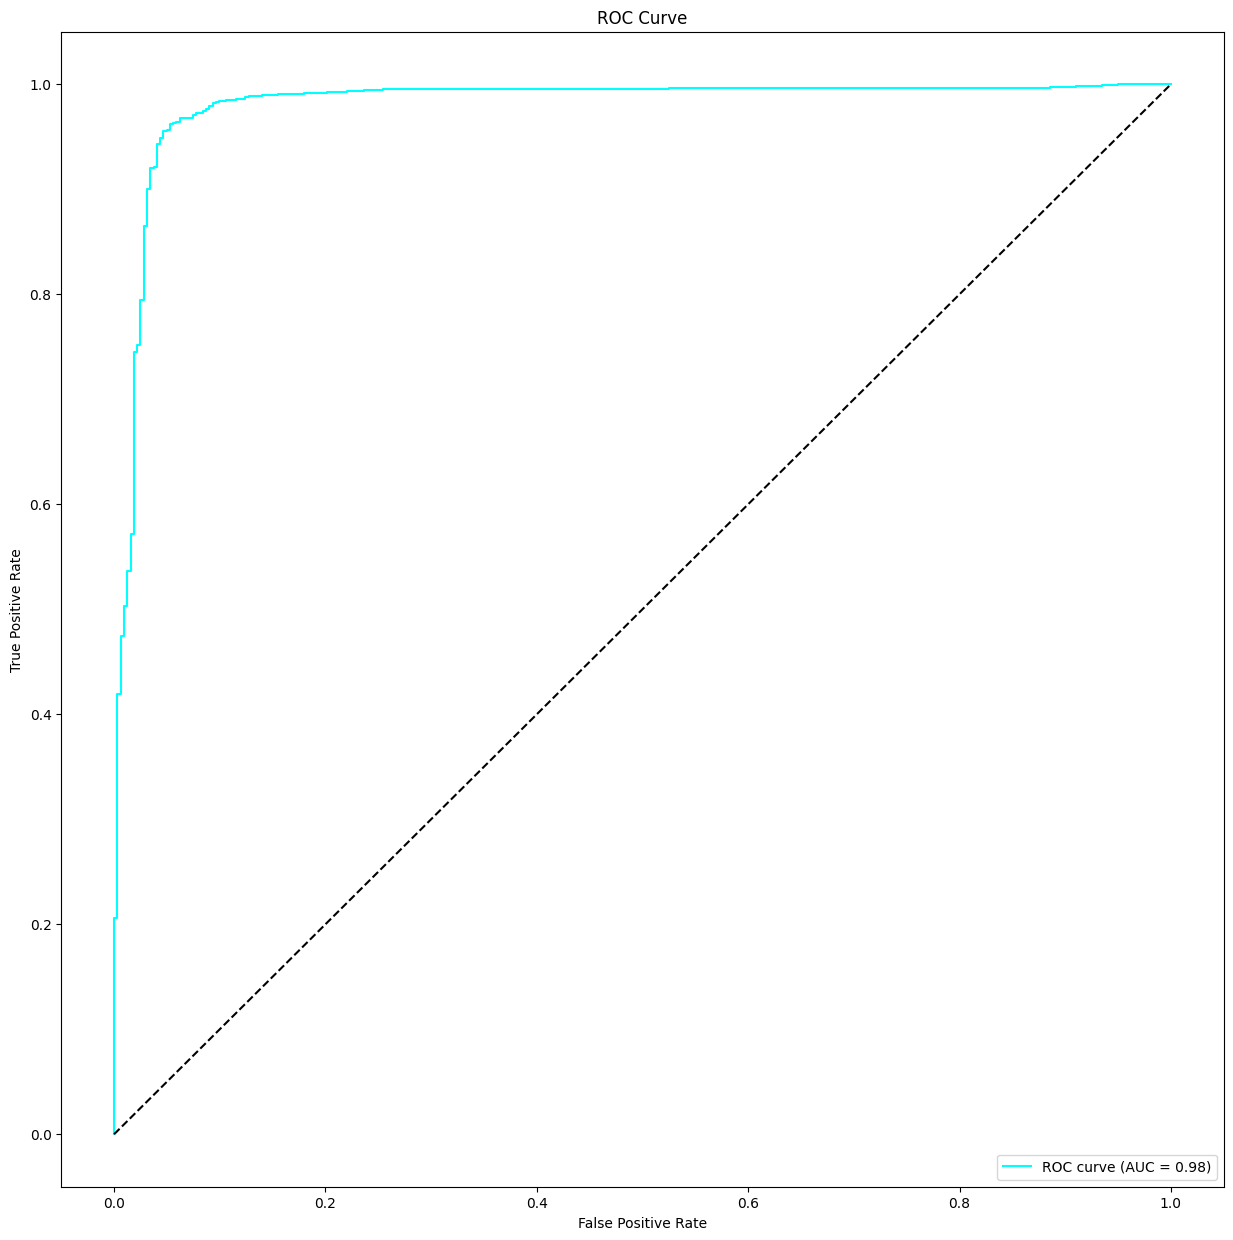

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       322
           1       0.99      0.99      0.99      4883

    accuracy                           0.98      5205
   macro avg       0.89      0.94      0.91      5205
weighted avg       0.98      0.98      0.98      5205

##################################################  Saliency Maps  ##################################################

Class 0:


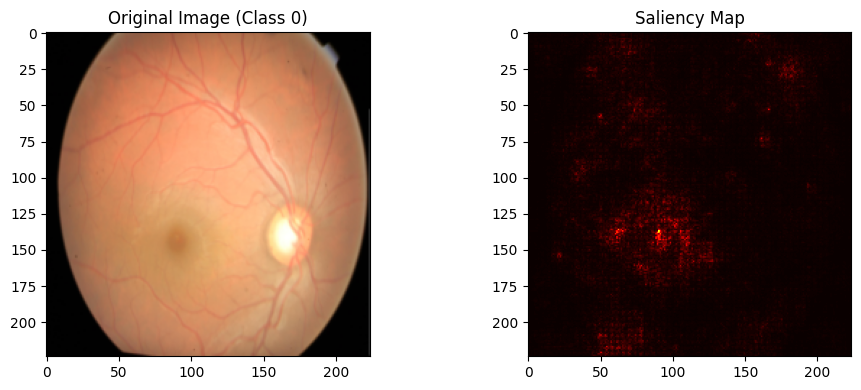

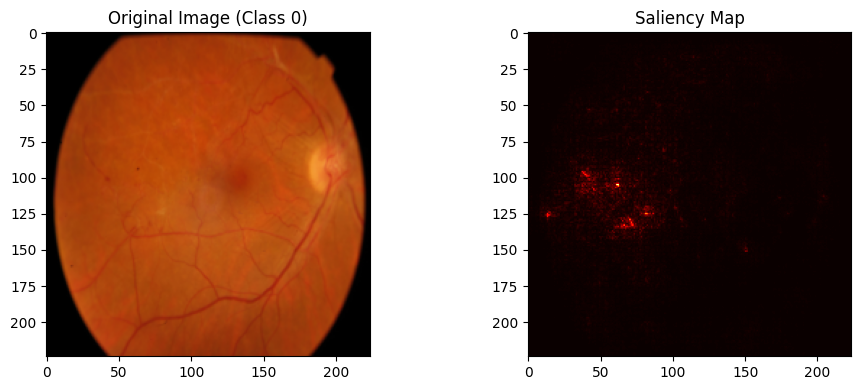

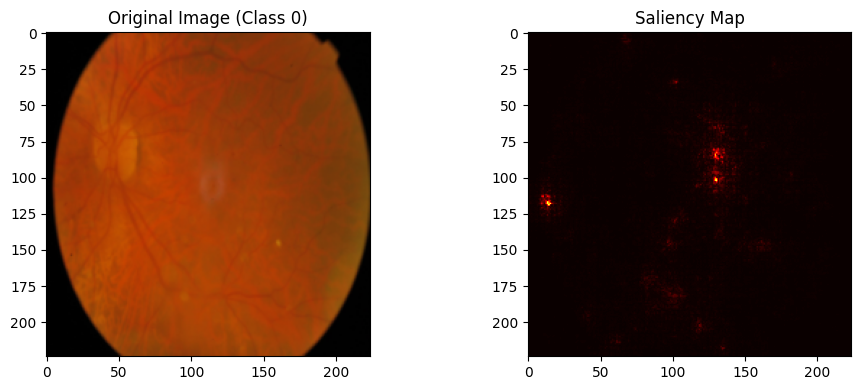

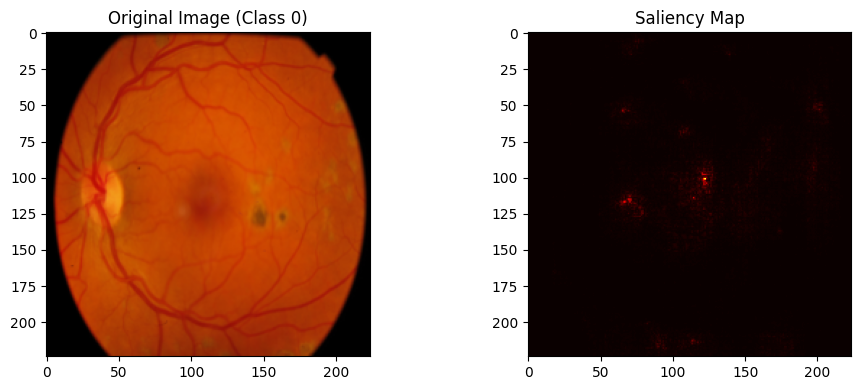

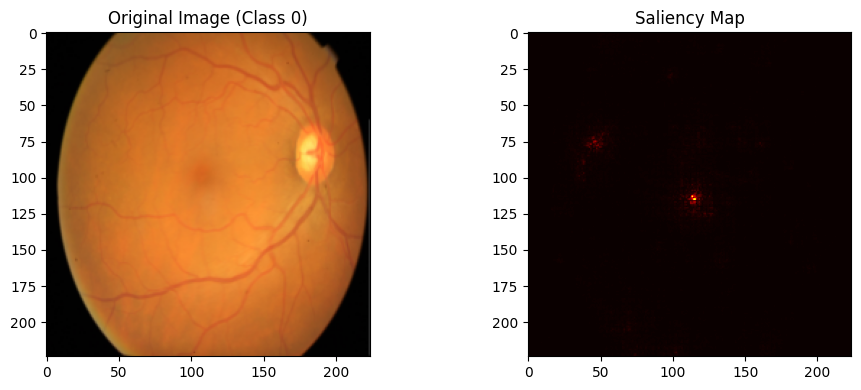

Class 1:


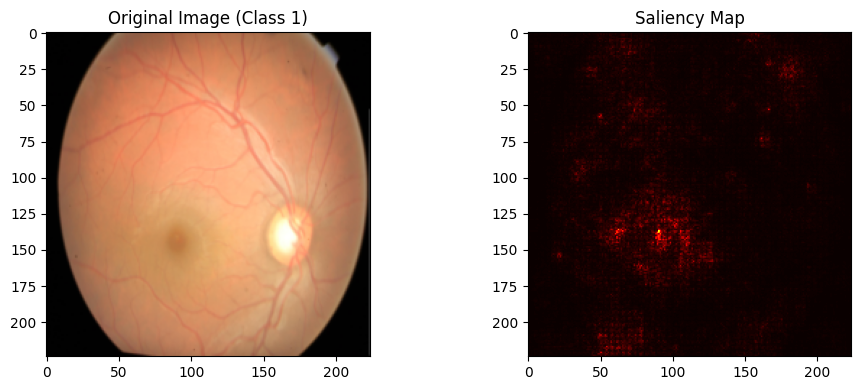

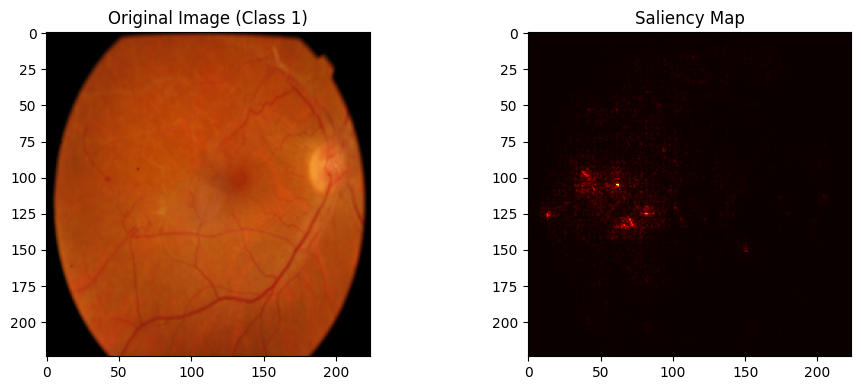

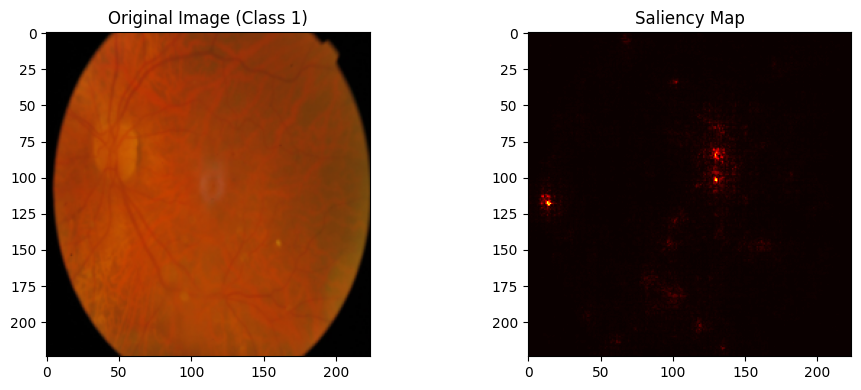

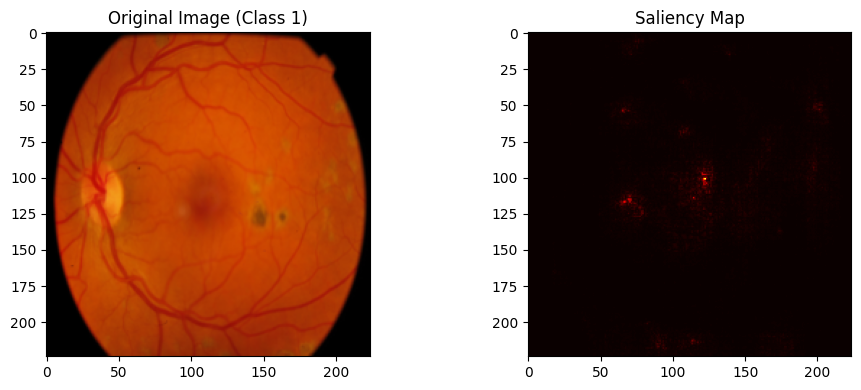

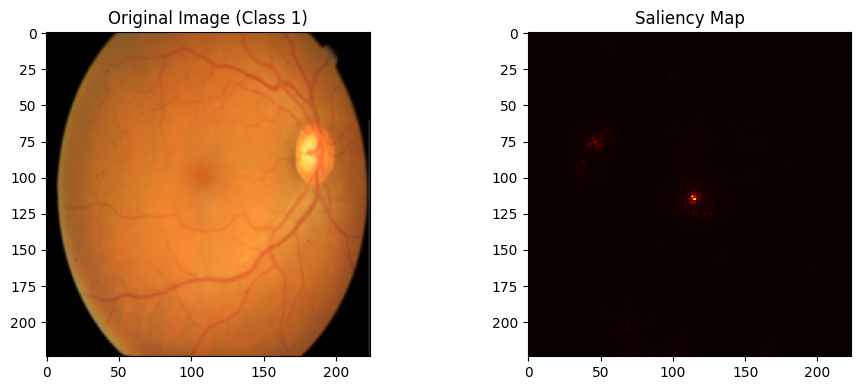

In [ ]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [ ]:
# Good quality images
adequate_df = df_test[df_test['quality'] == 'Adequate']

# Bad quality images
inadequate_df = df_test[df_test['quality'] == 'Inadequate']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 286/286 [01:19<00:00,  3.59it/s]


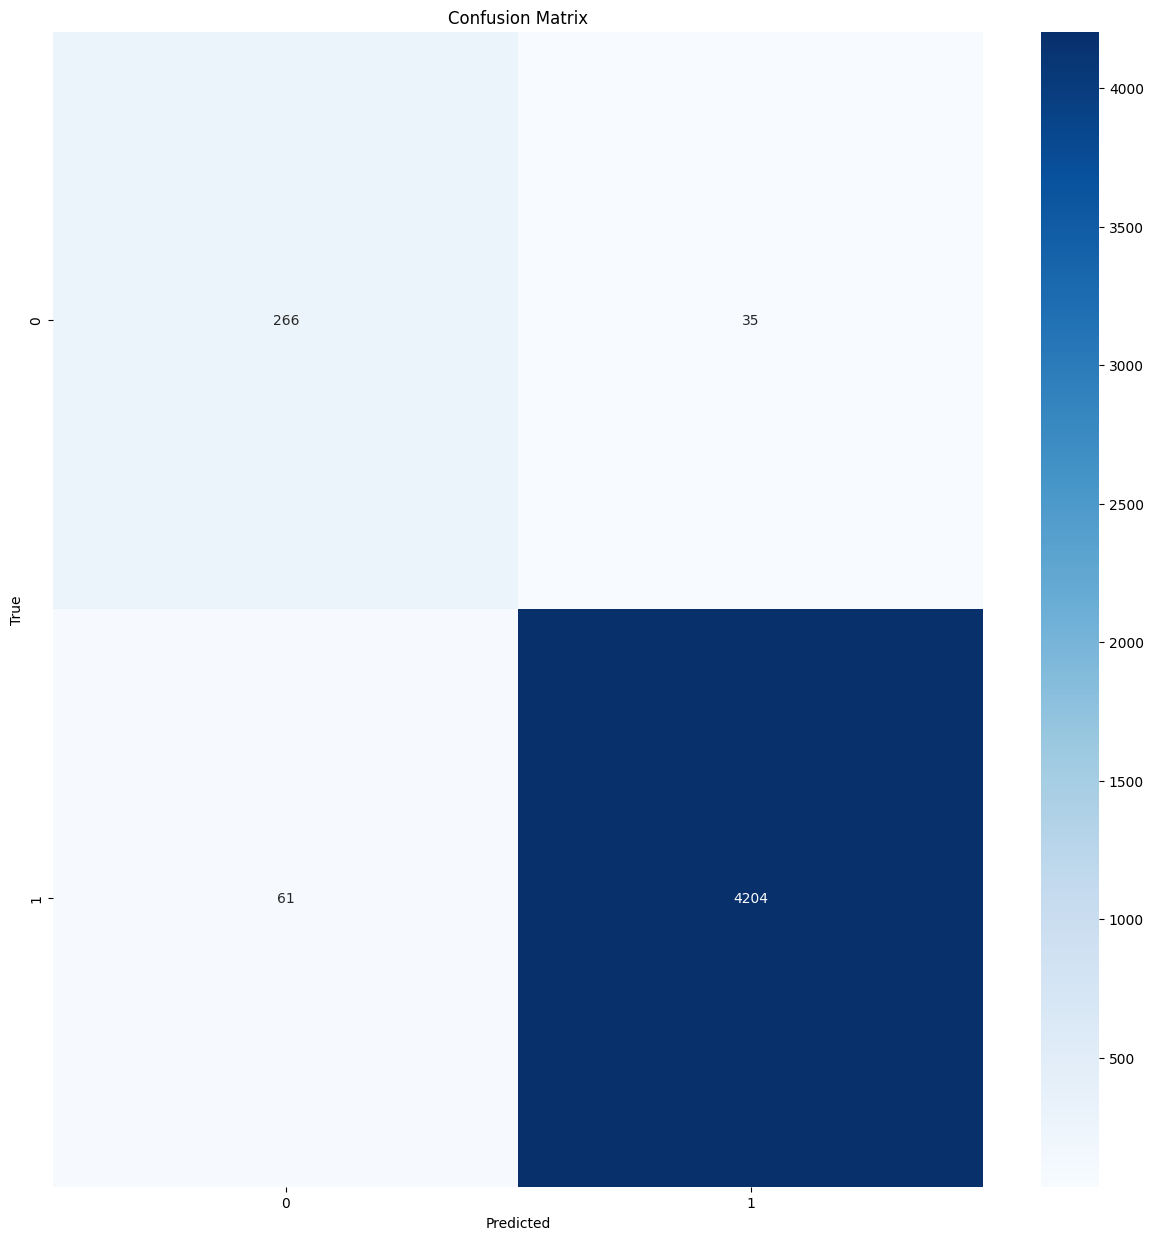

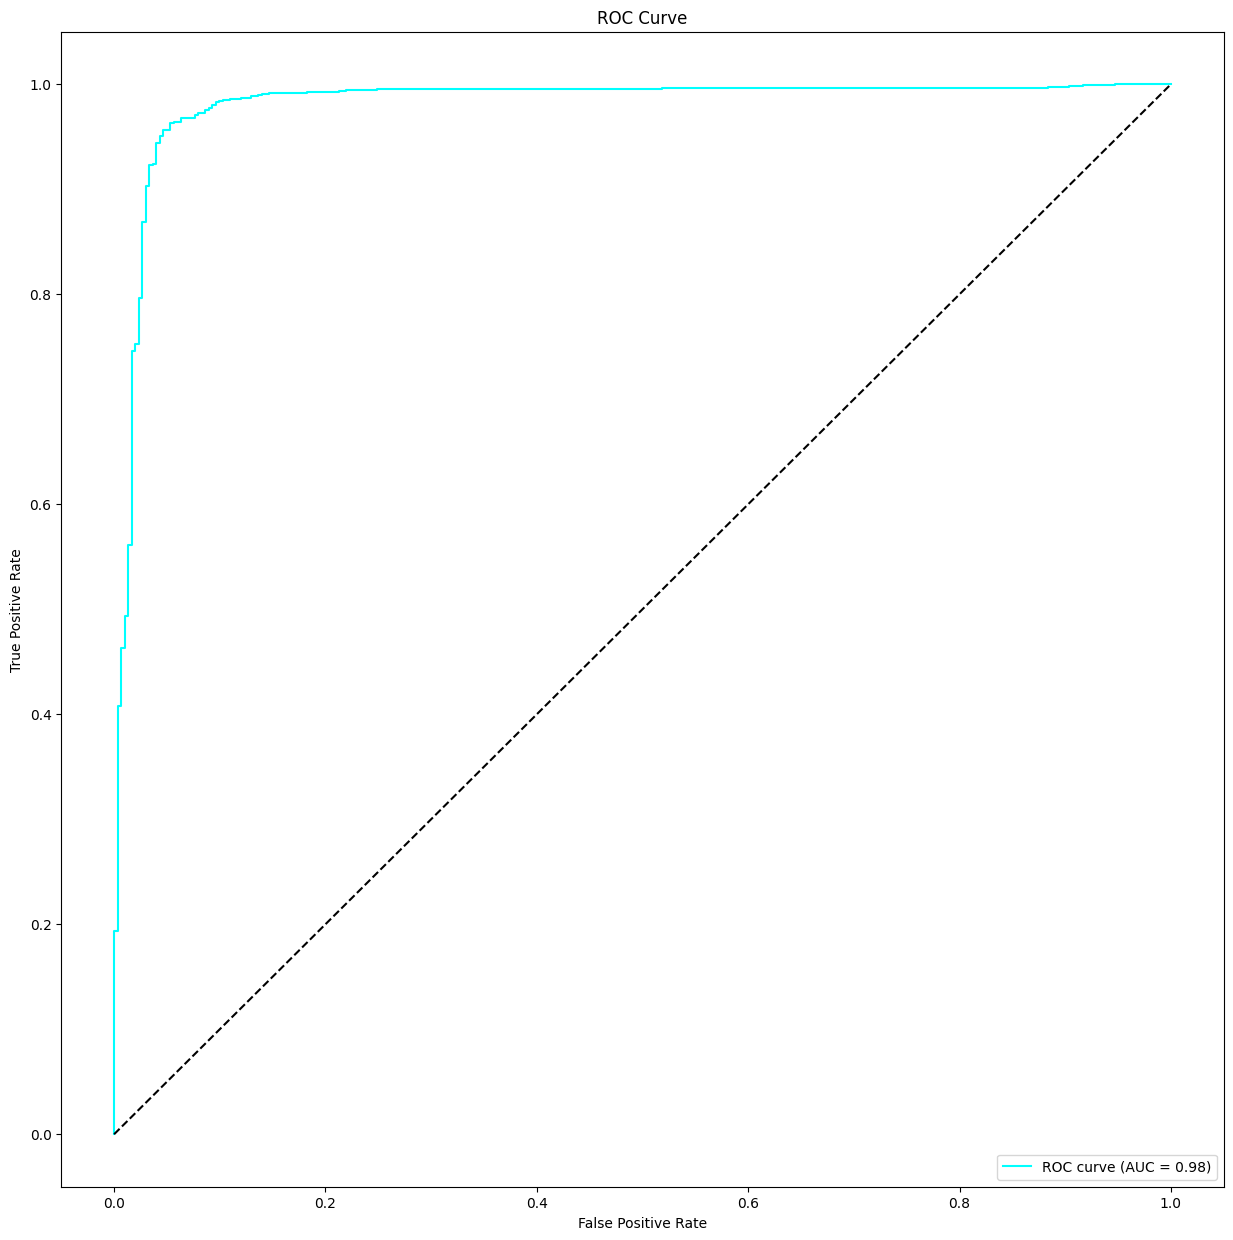

              precision    recall  f1-score   support

           0       0.81      0.88      0.85       301
           1       0.99      0.99      0.99      4265

    accuracy                           0.98      4566
   macro avg       0.90      0.93      0.92      4566
weighted avg       0.98      0.98      0.98      4566

##################################################  Saliency Maps  ##################################################

Class 0:


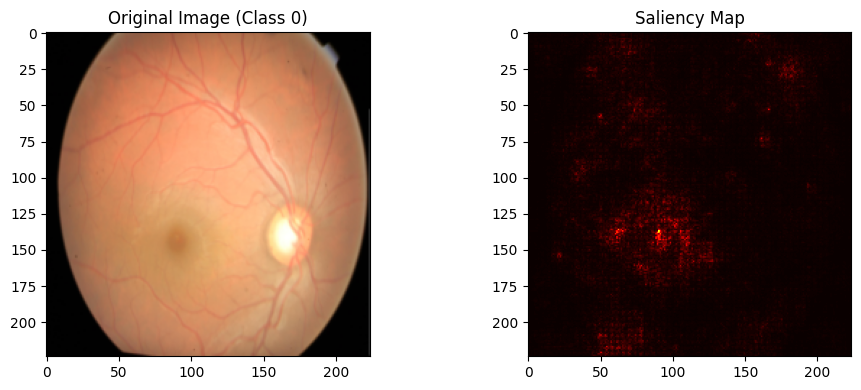

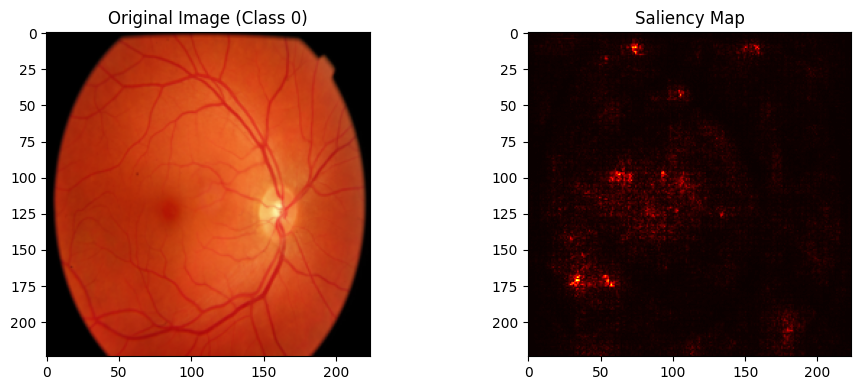

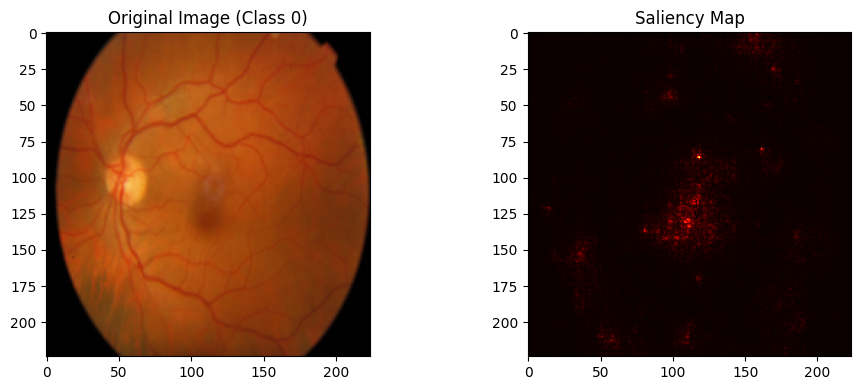

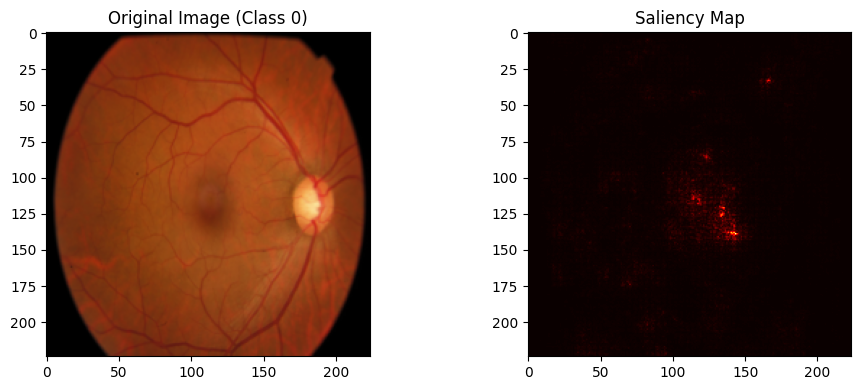

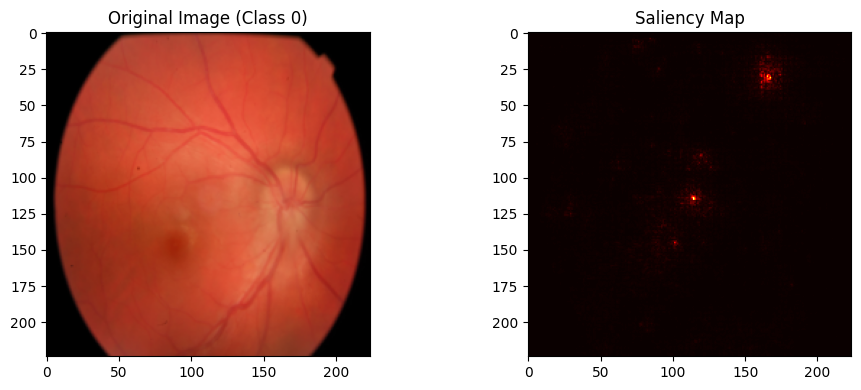

Class 1:


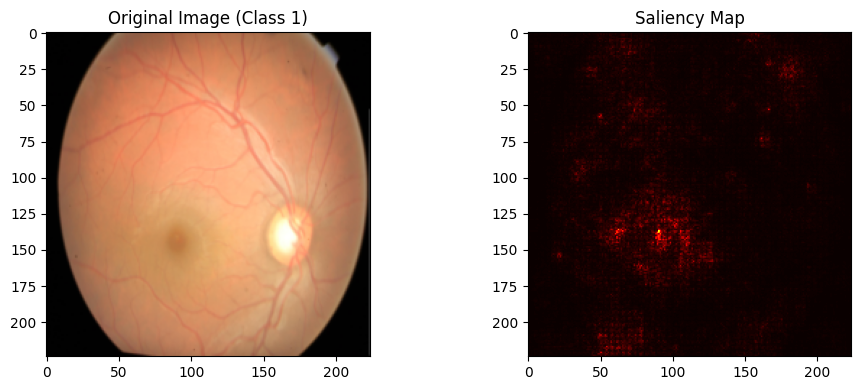

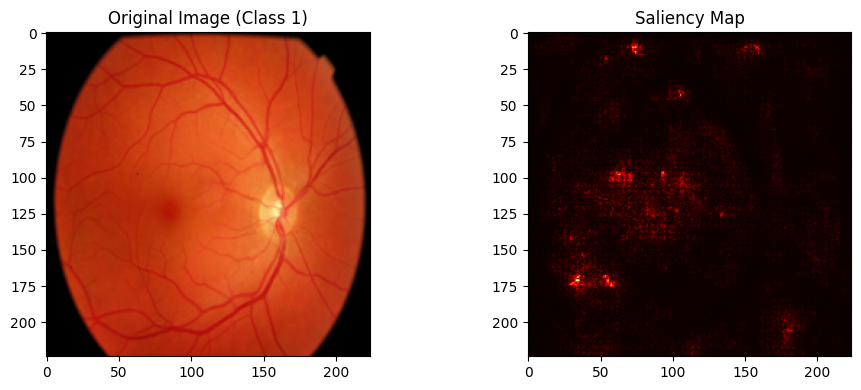

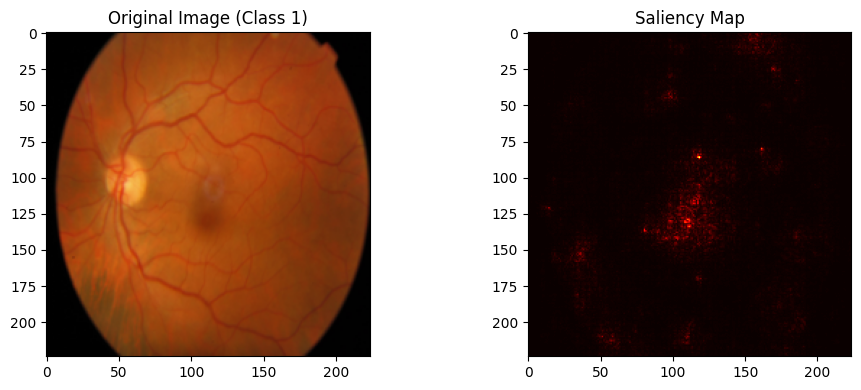

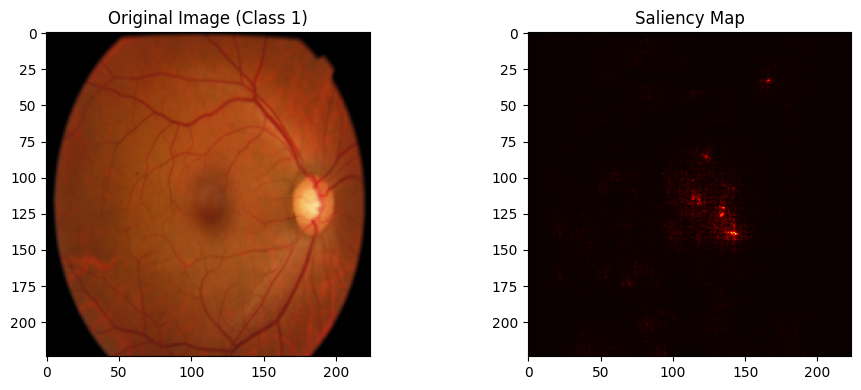

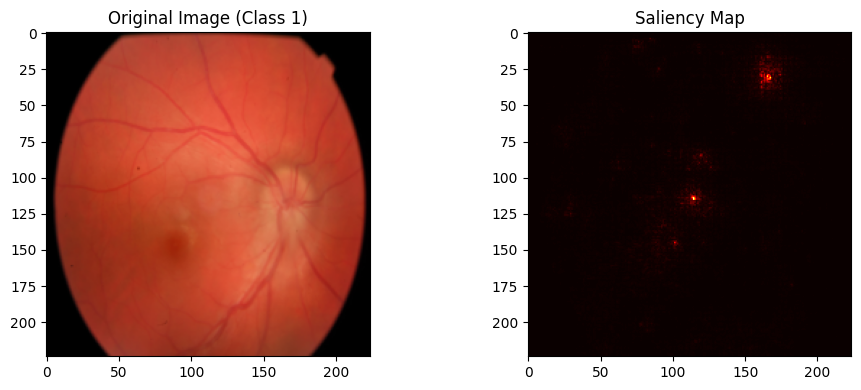

In [ ]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

100%|██████████| 40/40 [00:12<00:00,  3.33it/s]


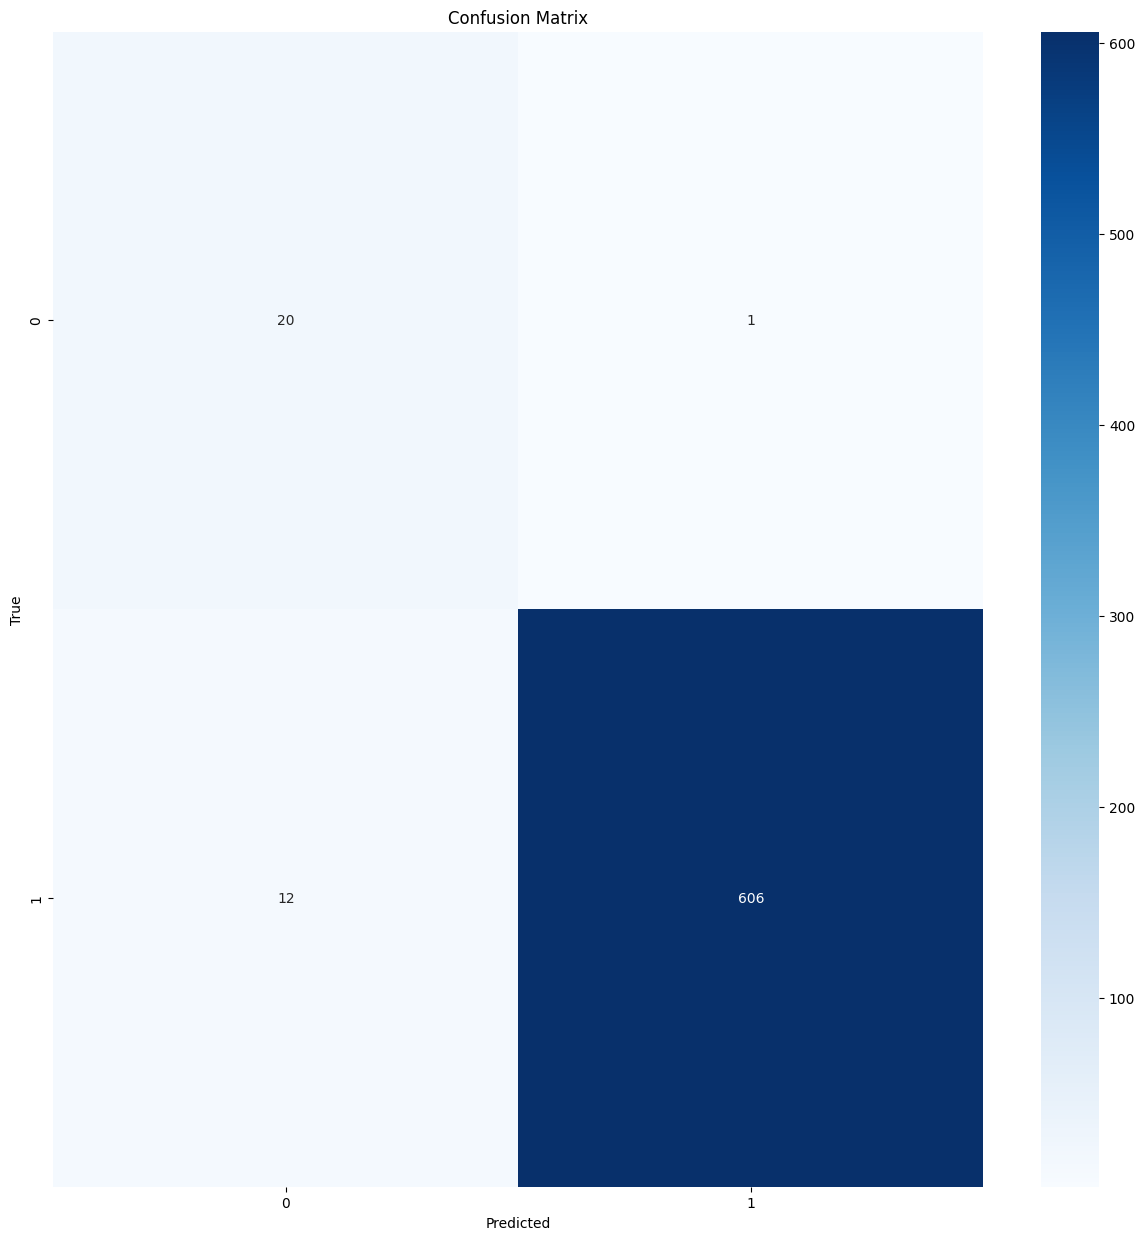

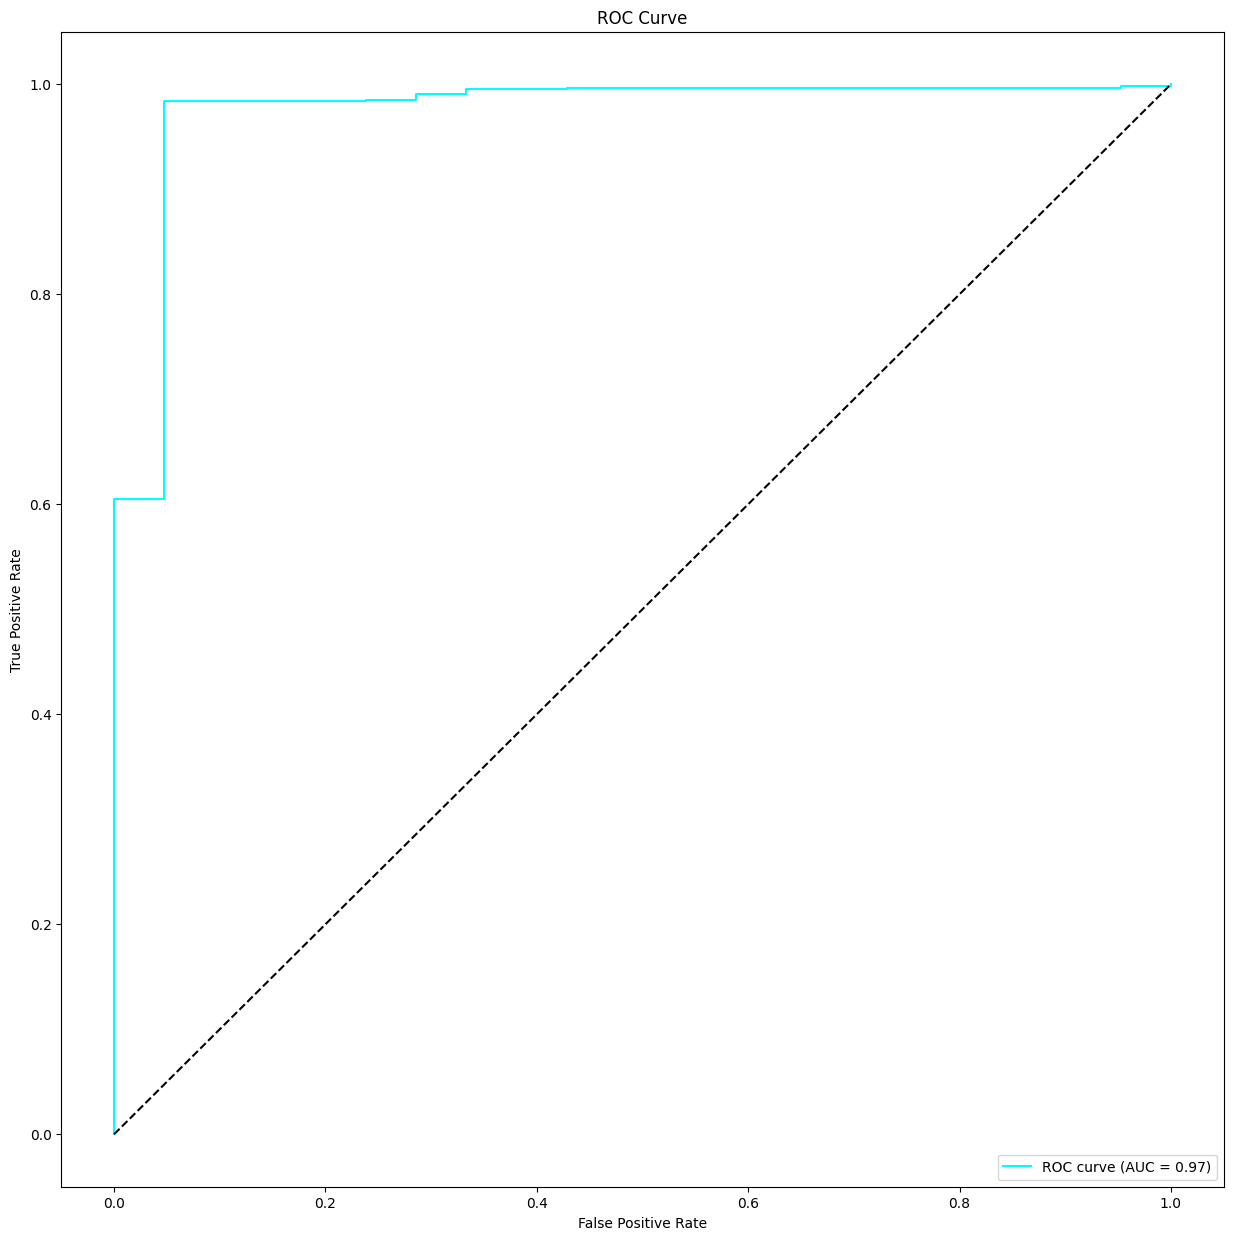

              precision    recall  f1-score   support

           0       0.62      0.95      0.75        21
           1       1.00      0.98      0.99       618

    accuracy                           0.98       639
   macro avg       0.81      0.97      0.87       639
weighted avg       0.99      0.98      0.98       639

##################################################  Saliency Maps  ##################################################

Class 0:


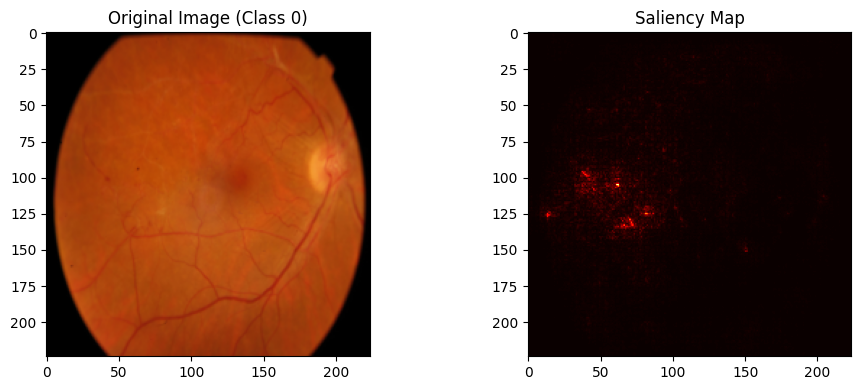

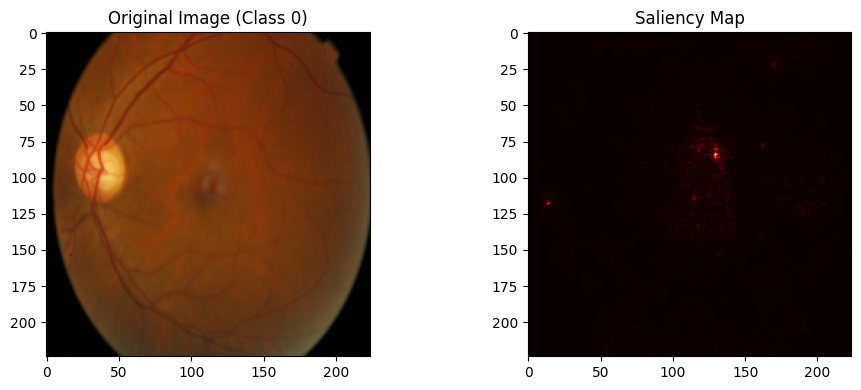

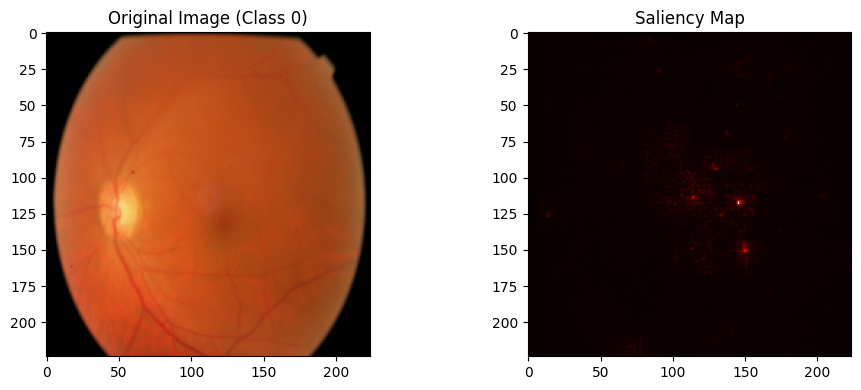

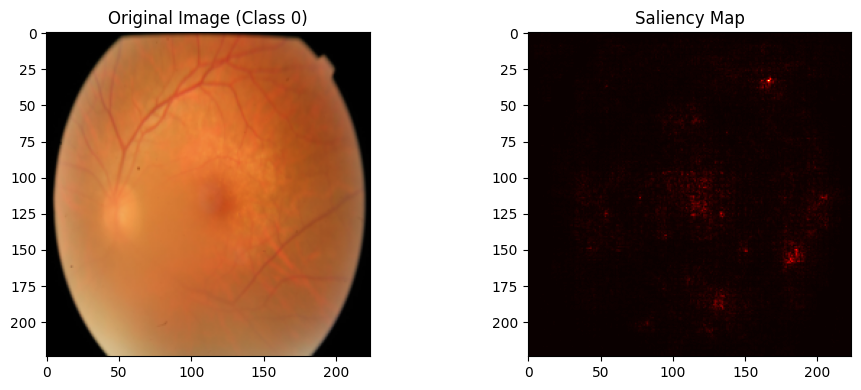

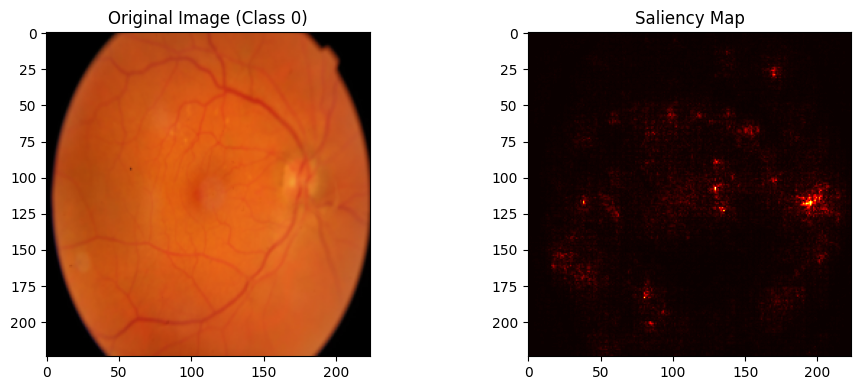

Class 1:


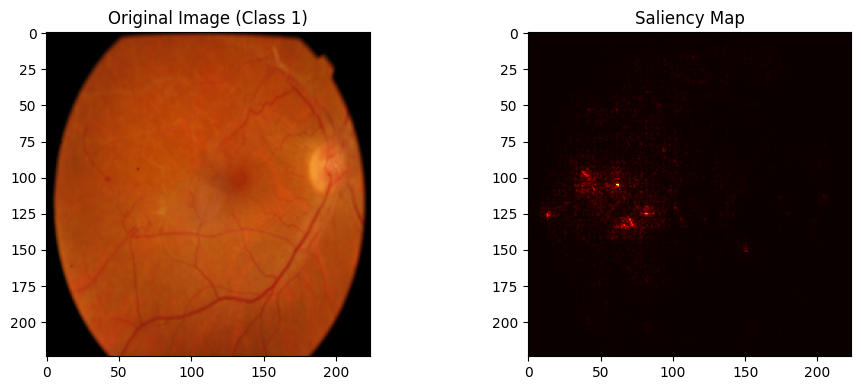

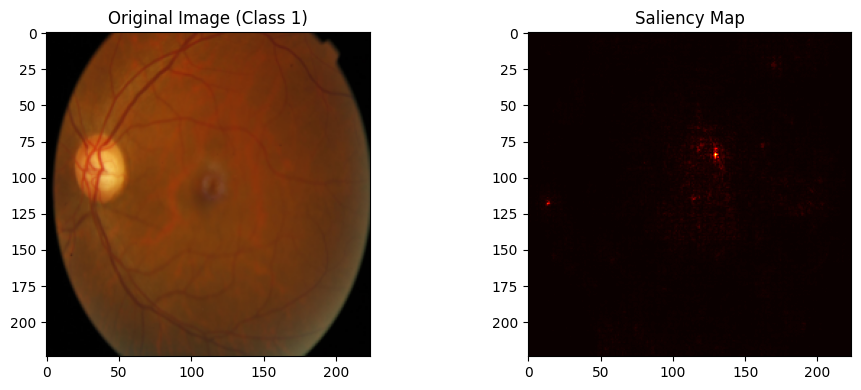

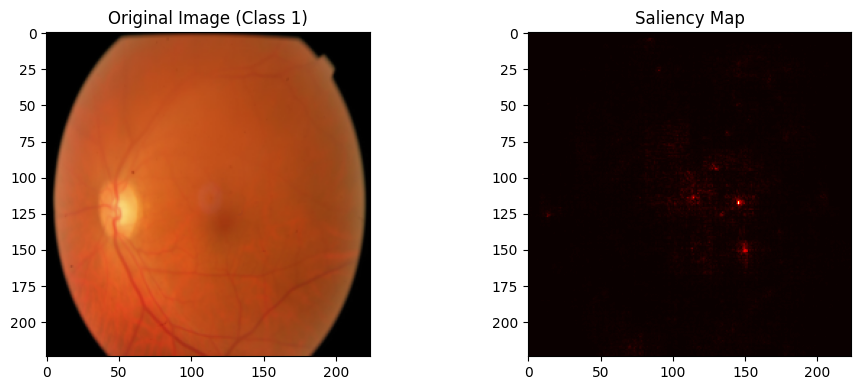

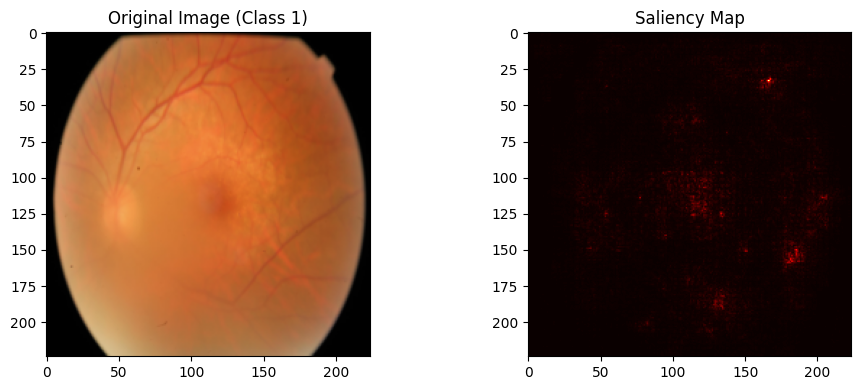

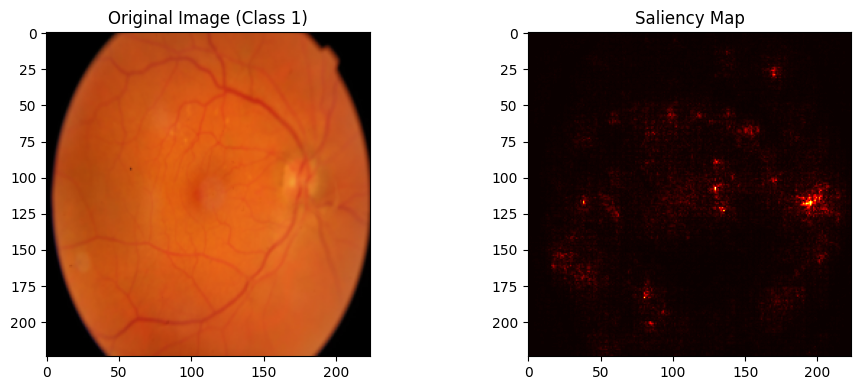

In [ ]:
test(model, inadequate_dataloader, saliency=True, device=device)